## Exercice n°1 (1/2 h)




Dans le modèle ci-dessous, pouvez-vous préciser :
- la taille du champ réceptif associé à un pixel d'une carte de caractéristique en sortie de enc3, par un calcul théorique.
- passer ce modèle sur un champ ne contenant que des zéros sauf pour une composante. En déduire la taille du champ réceptif empirique en sortie du modèle.


In the model below, can you specify:
- the size of the receptive field associated with a pixel of a feature map at the output of enc3, using a theoretical calculation.
- apply this model to a field containing only zeros except for one component. Deduce the size of the empirical receptive field at the output of the model.

In [3]:
import torch
import torch.nn as nn

class MyNN(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, base=16):
        super().__init__()

        # 2 Conv2D
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_ch, base, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(base, base, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
        )

        # 2 Conv2D, first with stride=2
        self.enc2 = nn.Sequential(
            nn.Conv2d(base, base * 2, kernel_size=3, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(base * 2, base * 2, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
        )

        # again 2 Conv2D, first with stride=2
        self.enc3 = nn.Sequential(
            nn.Conv2d(base * 2, base * 4, kernel_size=3, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(base * 4, base * 4, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
        )

        # alternance Conv2D / ConvTranspose2D
        self.mid = nn.Conv2d(base * 4, base * 4, kernel_size=3, padding=1, bias=False)

        self.up1 = nn.ConvTranspose2d(base * 4, base * 2, kernel_size=2, stride=2, bias=False)
        self.dec1 = nn.Conv2d(base * 2, base * 2, kernel_size=3, padding=1, bias=False)

        self.up2 = nn.ConvTranspose2d(base * 2, base, kernel_size=2, stride=2, bias=False)
        self.dec2 = nn.Conv2d(base, base, kernel_size=3, padding=1, bias=False)

        self.head = nn.Conv2d(base, out_ch, kernel_size=1, bias=False)

    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.enc3(x)

        x = torch.relu(self.mid(x))

        x = self.up1(x)
        x = torch.relu(self.dec1(x))

        x = self.up2(x)
        x = torch.relu(self.dec2(x))

        return self.head(x)

# Answer

## Course background

The receptive field of a feature map element is the region of the input that influenced it's value. It could be regarded as how much of an image/input data a neuron "sees".

The formula provided in the course, looks as follows:

Iniitialize:
$$R_0 = 1, J_0 = 1;$$
Then calculate $$R_n = R_{n-1} + (k_n -1) \ J_{n-1} $$
$$J_n = J_{n-1} \ s_n$$

with $k_n$ denoting the kernel size and $s_n$ the stride of layer $n$ .




*AI PROMPT*
```
Calculate the receptive field according to above formula,
by considering, the convolutions at enc1,2,3.
Each 2 convolutions, with kernel size=3 ,
and strides in ((1,1), (2, 1), (2, 1)).
Write all calculation steps and your results
in an appropriate mathematical format
```



*AI OUTPUT*

Let's calculate the receptive field (RF) and jump (J) for each layer within `enc1`, `enc2`, and `enc3`.

**Initialization:**
$R_0 = 1$
$J_0 = 1$

**1. `enc1` layers:**
   * **Layer 1 (k=3, s=1):**
     $R_1 = R_0 + (k_1 - 1) \times J_0 = 1 + (3 - 1) \times 1 = 1 + 2 = 3$
     $J_1 = J_0 \times s_1 = 1 \times 1 = 1$

   * **Layer 2 (k=3, s=1):**
     $R_2 = R_1 + (k_2 - 1) \times J_1 = 3 + (3 - 1) \times 1 = 3 + 2 = 5$
     $J_2 = J_1 \times s_2 = 1 \times 1 = 1$

**2. `enc2` layers:**
   * **Layer 1 (k=3, s=2):**
     $R_3 = R_2 + (k_3 - 1) \times J_2 = 5 + (3 - 1) \times 1 = 5 + 2 = 7$
     $J_3 = J_2 \times s_3 = 1 \times 2 = 2$

   * **Layer 2 (k=3, s=1):**
     $R_4 = R_3 + (k_4 - 1) \times J_3 = 7 + (3 - 1) \times 2 = 7 + 4 = 11$
     $J_4 = J_3 \times s_4 = 2 \times 1 = 2$

**3. `enc3` layers:**
   * **Layer 1 (k=3, s=2):**
     $R_5 = R_4 + (k_5 - 1) \times J_4 = 11 + (3 - 1) \times 2 = 11 + 4 = 15$
     $J_5 = J_4 \times s_5 = 2 \times 2 = 4$

   * **Layer 2 (k=3, s=1):**
     $R_6 = R_5 + (k_6 - 1) \times J_5 = 15 + (3 - 1) \times 4 = 15 + 8 = 23$
     $J_6 = J_5 \times s_6 = 4 \times 1 = 4$

**Result:**
The theoretical receptive field associated with a pixel of a feature map at the output of `enc3` is $\mathbf{23 \times 23}$.

*Critical Review*

The calculations are correct and well formatted, we are able to go through them successively

## Empirical receptive field (ERF) estimation via "impulse" input

To estimate the empirical receptive field, we use the classic “impulse response” method: create an input image that is zero everywhere except for one pixel (a discrete delta), pass it through the network, and observe which output pixels become non-zero. The set (or bounding box) of activated output pixels approximates the region influenced by that single input pixel, i.e., the receptive field. This directly mirrors the lecture’s concept of receptive field growth across layers (kernels and strides expand how much of the input can affect one activation), but instead of computing it symbolically, we measure it experimentally by probing the network with a localized stimulus.

Input shape : (1, 3, 128, 128)
Output shape: (1, 1, 128, 128)

Empirical receptive field (ERF) bounding box in the OUTPUT:
y in [49, 82], x in [49, 82]
ERF size ≈ 34 x 34 pixels (height x width)


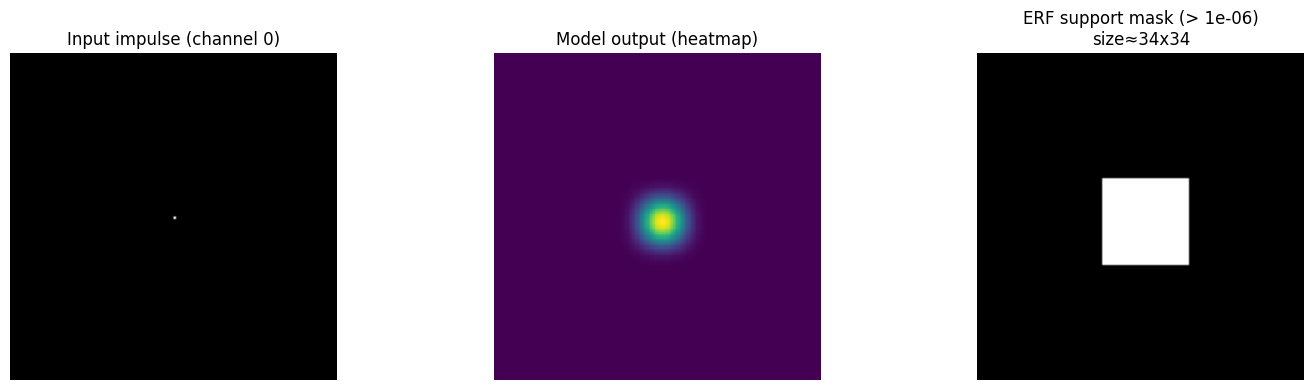

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 0) Helper: make weights positive (optional but recommended)
# ----------------------------
def make_all_conv_weights_positive(module, w_value=1.0):
    """
    To avoid ReLU hiding parts of the receptive field due to negative pre-activations,
    we set all conv / convtranspose weights to a positive constant.
    This makes the impulse response mostly positive, so support is easier to measure.
    """
    for m in module.modules():
        if isinstance(m, (torch.nn.Conv2d, torch.nn.ConvTranspose2d)):
            with torch.no_grad():
                m.weight.fill_(w_value)


# ----------------------------
# 1) Build the model and put it in eval mode
# ----------------------------
model = MyNN(in_ch=3, out_ch=1, base=16)
model.eval()

# Optional but recommended for robust ERF visualization with ReLU:
make_all_conv_weights_positive(model, w_value=1.0)


# ----------------------------
# 2) Create an "impulse" input (all zeros except 1 pixel)
# ----------------------------
# Choose a reasonably large spatial size so the receptive field fits far from borders.
H, W = 128, 128

x = torch.zeros(1, 3, H, W)  # (batch=1, channels=3, H, W)

# Put the impulse at the center (to avoid border effects)
cy, cx = H // 2, W // 2

# Set one component to 1 (one pixel in one channel)
# You can also set all channels to 1; one channel is enough to probe ERF.
x[0, 0, cy, cx] = 1.0


# ----------------------------
# 3) Forward pass
# ----------------------------
with torch.no_grad():
    y = model(x)  # expected shape: (1, 1, H, W) with this architecture

print("Input shape :", tuple(x.shape))
print("Output shape:", tuple(y.shape))


# ----------------------------
# 4) Measure the empirical receptive field support at the output
# ----------------------------
# Due to floating point operations, values may not be exactly zero.
# Use a small threshold to decide "active" pixels.
eps = 1e-6
mask = (y.abs() > eps)[0, 0]  # remove batch/channel -> shape (H, W)

nonzero = mask.nonzero(as_tuple=False)  # tensor of shape (K, 2): (row=y, col=x)

if nonzero.numel() == 0:
    print("No non-zero response detected. Try increasing weight magnitude or lowering eps.")
else:
    y_min = int(nonzero[:, 0].min().item())
    y_max = int(nonzero[:, 0].max().item())
    x_min = int(nonzero[:, 1].min().item())
    x_max = int(nonzero[:, 1].max().item())

    erf_h = y_max - y_min + 1
    erf_w = x_max - x_min + 1

    print("\nEmpirical receptive field (ERF) bounding box in the OUTPUT:")
    print(f"y in [{y_min}, {y_max}], x in [{x_min}, {x_max}]")
    print(f"ERF size ≈ {erf_h} x {erf_w} pixels (height x width)")

    # ----------------------------
    # 5) Visualization: ERF mask and output heatmap
    # ----------------------------
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Show impulse location in the input (channel 0)
    axes[0].imshow(x[0, 0].cpu().numpy(), cmap="gray")
    axes[0].set_title("Input impulse (channel 0)")
    axes[0].axis("off")

    # Show the output response heatmap
    axes[1].imshow(y[0, 0].cpu().numpy(), cmap="viridis")
    axes[1].set_title("Model output (heatmap)")
    axes[1].axis("off")

    # Show the ERF support mask
    axes[2].imshow(mask.cpu().numpy(), cmap="gray")
    axes[2].set_title(f"ERF support mask (> {eps})\nsize≈{erf_h}x{erf_w}")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()
